## Caution: experimental file, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

In [2]:
import sys
sys.path.append('..')

import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
logging.getLogger("matplotlib").setLevel(logging.WARNING)

from functools import reduce
from pathlib import Path

from modules.cae_base_module import CAEBaseModule
from modules.vae_base_module import VAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.pca_base_module import PCABaseModule
from models import supported_models
from datasets import supported_datamodules
from utils import tools, metrics, supported_preprocessing_transforms

plt.style.use('../utils/_extras/primary.mplstyle')

In [3]:
# Import configurations and paths to logged models
root = Path.cwd() / '..'
log_path = root / 'logs' / 'NoveltyMNISTDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
SimpleVAE/archive_v1_2021-04-21
SimpleAAE/archive_v3_2021-05-07
BaselineCAE/archive_v1_2021-04-12
CompressionCAEHighCapacity/archive_v1_2021-04-15
StandardPCA/archive_v2_2021-04-21
CompressionCAEMidCapacity/archive_v1_2021-04-15
CompressionCAEMidCapacity/archive_v2_2021-04-15


In [4]:
# Load the checkpoints for all the training modules and save them in a dictionary
module_catalog = {}

for pth in paths_to_archived_models:
    
    model_type = pth.parent.name
    model_name = pth.name
    config = tools.load_config(pth / 'configuration.yaml', silent=True)
    
    # Unsupervising region proposal is called implicity in this line, see utils/preprocessing.py
    preprocessing_transforms = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]

    datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
        data_transforms=preprocessing_transforms,
        **config['data-parameters'])
    
    if 'PCA' in model_type:

        _, pca_test_labels = datamodule.split(train=False)
        
        with open(pth / 'fitted_model.p', 'rb') as f:
            model = pickle.load(f)
            module = PCABaseModule(model)
    else:
        ckpt_path = next(iter((pth / 'checkpoints').glob('val_*')))

        datamodule.setup('test')

        # Handle the various model instantiations
        if 'AAE' in model_type:
            model = supported_models[model_type](
                in_shape=datamodule.data_shape,
                latent_nodes=config['module-parameters']['latent_nodes'])
            module = AAEBaseModule(model, **config['module-parameters'])
        elif 'VAE' in model_type:
            model = supported_models[model_type](
                in_shape=datamodule.data_shape,
                latent_nodes=config['module-parameters']['latent_nodes'])
            module = VAEBaseModule(model, **config['module-parameters'])
        elif 'CAE' in model_type:
            model = supported_models[model_type](in_shape=datamodule.data_shape)
            module = CAEBaseModule(model, **config['module-parameters'])
        else:
            raise ValueError(f'Model substring not found, got {model_type}')

        # Load the state_dict into the module architecture
        checkpoint = torch.load(ckpt_path)
        module.load_state_dict(checkpoint['state_dict'])
    
    if model_type not in module_catalog:
        module_catalog[model_type] = {}
    module_catalog[model_type][model_name] = module
    print(f'Loaded state dict for: {model_type}/{model_name}')

Loaded state dict for: SimpleVAE/archive_v1_2021-04-21
Loaded state dict for: SimpleAAE/archive_v3_2021-05-07
Loaded state dict for: BaselineCAE/archive_v1_2021-04-12
Loaded state dict for: CompressionCAEHighCapacity/archive_v1_2021-04-15
Loaded state dict for: StandardPCA/archive_v2_2021-04-21
Loaded state dict for: CompressionCAEMidCapacity/archive_v1_2021-04-15
Loaded state dict for: CompressionCAEMidCapacity/archive_v2_2021-04-15


In [5]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'scores': [], 
                'labels': []
            }
        print(f'------\n{short_name}\n------')
        
        # Handle the PCA and autoencoder frameworks separately
        if 'PCA' in short_name:
            test_novelty_scores = module.transform_pipeline(datamodule)
            test_novelty_labels = pca_test_labels
        else:
        
            # Set the model/components in evaluation mode
            if 'AAE' in model_type:
                module.encoder.eval()
                module.decoder.eval()
            else:
                module.model.eval()
        
            with torch.no_grad():
                for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                    result = module.test_step(batch, batch_nb)

                    test_novelty_scores.extend(result['scores'])
                    test_novelty_labels.extend(result['labels'].cpu().numpy())
                    print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
SimpleVAE-v1
------
[BATCH 0] Mean score: 0.34454262256622314
[BATCH 1] Mean score: 0.3498416543006897
[BATCH 2] Mean score: 0.3446768522262573
[BATCH 3] Mean score: 0.350930392742157
[BATCH 4] Mean score: 0.3500346541404724
[BATCH 5] Mean score: 0.34127944707870483
[BATCH 6] Mean score: 0.3503343462944031
[BATCH 7] Mean score: 0.34775274991989136
[BATCH 8] Mean score: 0.3480188846588135
[BATCH 9] Mean score: 0.34523412585258484
SimpleVAE-v1 Time: 2.60 s

------
SimpleAAE-v3
------
[BATCH 0] Mean score: 0.5745812058448792
[BATCH 1] Mean score: 0.579025387763977
[BATCH 2] Mean score: 0.5741379857063293
[BATCH 3] Mean score: 0.576151430606842
[BATCH 4] Mean score: 0.5782550573348999
[BATCH 5] Mean score: 0.5794404149055481
[BATCH 6] Mean score: 0.5775456428527832
[BATCH 7] Mean score: 0.5788815021514893
[BATCH 8] Mean score: 0.5770773887634277
[BATCH 9] Mean score: 0.5749516487121582
SimpleAAE-v3 Time: 1.04 s

------
BaselineCAE-v1
------
[BATCH 0] Mean score: 0.2508472204208374
[

SimpleVAE-v1: 3473.131591796875
SimpleAAE-v3: 5770.53466796875
BaselineCAE-v1: 2516.391357421875
CompressionCAEHighCapacity-v1: 2862.93408203125
StandardPCA-v2: 1.6779717100269127e-22
CompressionCAEMidCapacity-v1: 2968.94384765625
CompressionCAEMidCapacity-v2: 3093.654296875


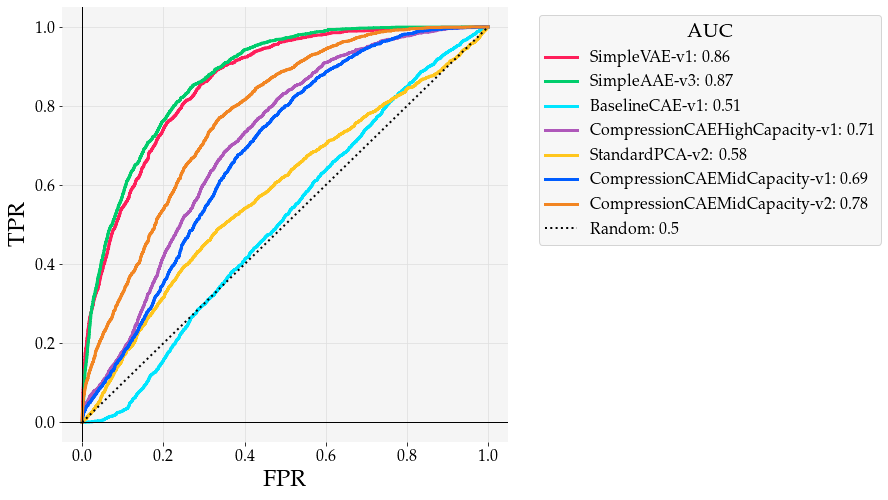

Random ROC AUC: 0.5


In [73]:
# Plot the ROC curves with AUCs for each model
plt.style.use('../utils/_extras/primary.mplstyle')

fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():

    scores = results['scores']
    labels = results['labels']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, labels)
    
    ax.plot(fpr, tpr, label=f'{sn}: {auc:.2f}')
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

plt.savefig('ROC-all_NoveltyMNIST.pdf', format='pdf', bbox_inches='tight')
plt.show()
print('Random ROC AUC: 0.5')

By evaluating the Precision(k) across all test samples, we make the assumption that all the samples are of the positive class. Clearly this iss an erroneous assumption; conceptually, we should evaluate the Precision(k) only for the novel samples. But this sort of evaluation places a bias on the use of Precision(k) to measure the performance of our detector. By the definition of a novelty, is *cannot* be known beforehand their exact number or frequency. Therefore by analyzing Precision(k) only for the samples we know are novel, because we have insider information about the test data (e.g. labels), we are only evaluating misclassifications of the positive class. Knowing the proportion of correct novelty predictions to total novelty predictions (precision) is important, but it omits a crucial aspect of the usefullness of a detector. Namely, how many *more* false positives would 'flood the results' if typical images were included in the analysis---which they *would* be in an operational scenario.

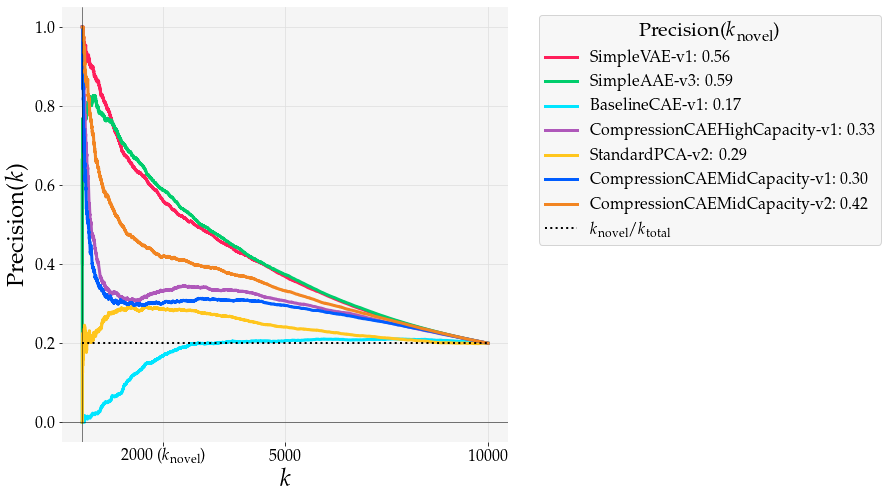

In [74]:
# Plot the Precision(k) across all test images.
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():
    
    scores = results['scores']
    labels = results['labels']
    pak = metrics.precision_at_k(scores, labels)

    uniques, counts = np.unique(labels, return_counts=True)
    random = counts.min() / counts.sum()

    ax.plot(pak, label=f'{sn}: {pak[int(sum(labels))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([2000, int(counts.sum()/2), counts.sum()])
ax.set_xticklabels(['2000 ($k_{\mathrm{novel}}$)', int(counts.sum()/2), counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-all_NoveltyMNIST.pdf', format='pdf', bbox_inches='tight')
plt.show()

With the `result_catalog` everything that is needed to analyze and graph results from the archived models trained on Novelty MNIST are available and can be added below. New models that are created according to the system used above can be easily integrated into this experiment and tested in further steps.